In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/kaggle/input/mhsmadataset/y_head_test.npy
/kaggle/input/mhsmadataset/y_head_valid.npy
/kaggle/input/mhsmadataset/y_tail_test.npy
/kaggle/input/mhsmadataset/y_acrosome_valid.npy
/kaggle/input/mhsmadataset/y_head_train.npy
/kaggle/input/mhsmadataset/y_acrosome_train.npy
/kaggle/input/mhsmadataset/x_64_valid.npy
/kaggle/input/mhsmadataset/y_tail_train.npy
/kaggle/input/mhsmadataset/x_64_test.npy
/kaggle/input/mhsmadataset/y_tail_valid.npy
/kaggle/input/mhsmadataset/y_acrosome_test.npy
/kaggle/input/mhsmadataset/x_64_train.npy
/kaggle/input/mhsmadataset/y_vacuole_valid.npy
/kaggle/input/mhsmadataset/x_128_valid.npy
/kaggle/input/mhsmadataset/x_128_train.npy
/kaggle/input/mhsmadataset/y_vacuole_train.npy
/kaggle/input/mhsmadataset/x_128_test.npy
/kaggle/input/mhsmadataset/y_vacuole_test.npy


device(type='cpu')

# Input dataframes

## train data

In [4]:
X_train = np.load("/kaggle/input/mhsmadataset/x_64_train.npy")
y_train_vacuole = np.load("/kaggle/input/mhsmadataset/y_vacuole_train.npy")
y_train_acrosome = np.load("/kaggle/input/mhsmadataset/y_acrosome_train.npy")
y_train_head = np.load("/kaggle/input/mhsmadataset/y_head_train.npy")

# check shapes of input
display(X_train.shape)
display(y_train_vacuole.shape)
display(y_train_acrosome.shape)
display(y_train_head.shape)

# check for NaN values
display(np.isnan(np.sum(X_train)))
display(np.isnan(np.sum(y_train_vacuole)))
display(np.isnan(np.sum(y_train_acrosome)))
display(np.isnan(np.sum(y_train_head)))

(1000, 64, 64)

(1000,)

(1000,)

(1000,)

False

False

False

False

## valid data

In [3]:
X_valid = np.load("/kaggle/input/mhsmadataset/x_64_valid.npy")
y_valid_vacuole = np.load("/kaggle/input/mhsmadataset/y_vacuole_valid.npy")
y_valid_acrosome = np.load("/kaggle/input/mhsmadataset/y_acrosome_valid.npy")
y_valid_head = np.load("/kaggle/input/mhsmadataset/y_head_valid.npy")

# check shapes of input
display(X_valid.shape)
display(y_valid_vacuole.shape)
display(y_valid_acrosome.shape)
display(y_valid_head.shape)

# check for NaN values
display(np.isnan(np.sum(X_valid)))
display(np.isnan(np.sum(y_valid_vacuole)))
display(np.isnan(np.sum(y_valid_acrosome)))
display(np.isnan(np.sum(y_valid_head)))

(240, 64, 64)

(240,)

(240,)

(240,)

False

False

False

False

## test data

In [4]:
X_test = np.load("/kaggle/input/mhsmadataset/x_64_test.npy")
y_test_vacuole = np.load("/kaggle/input/mhsmadataset/y_vacuole_test.npy")
y_test_acrosome = np.load("/kaggle/input/mhsmadataset/y_acrosome_test.npy")
y_test_head = np.load("/kaggle/input/mhsmadataset/y_head_test.npy")

# check shapes of input
display(X_test.shape)
display(y_test_vacuole.shape)
display(y_test_acrosome.shape)
display(y_test_head.shape)

# check for NaN values
display(np.isnan(np.sum(X_test)))
display(np.isnan(np.sum(y_test_vacuole)))
display(np.isnan(np.sum(y_test_acrosome)))
display(np.isnan(np.sum(y_test_head)))

(300, 64, 64)

(300,)

(300,)

(300,)

False

False

False

False

# Some of the images

Text(0.05, 0.1, 'vacuole: 0\nacrosome: 1\nhead: 0')

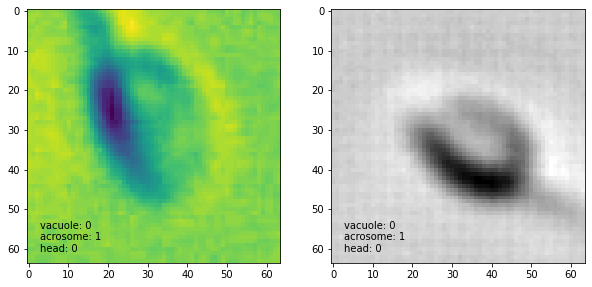

In [5]:
i = 11
f = i*25
s = i*50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.imshow(X_train[f])
ax1.text(0.05, 0.1,
         f"vacuole: {y_train_vacuole[f]}\nacrosome: {y_train_acrosome[f]}\nhead: {y_train_head[f]}", 
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax1.transAxes)

ax2.imshow(X_train[s], cmap='gray')
ax2.text(0.05, 0.1,
         f"vacuole: {y_train_vacuole[s]}\nacrosome: {y_train_acrosome[s]}\nhead: {y_train_head[s]}", 
         horizontalalignment='left',
         verticalalignment='center',
         transform=ax2.transAxes)

# Create Dataset and DataLoader

In [6]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, vacuoles, acrosomes, heads, imagesize):
        self.imagesize = imagesize
        self.images = images / 255.0
        self.vacuoles = vacuoles
        self.acrosomes = acrosomes
        self.heads = heads

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        return {
            'images': self.images[item].astype("float32").reshape(1, self.imagesize, self.imagesize),
            'vacuoles': torch.tensor(self.vacuoles[item], dtype=torch.long),
            'acrosomes': torch.tensor(self.vacuoles[item], dtype=torch.long),
            'heads': torch.tensor(self.vacuoles[item], dtype=torch.long)
        }

In [7]:
train_dataset = ImagesDataset(images=X_train,
                              vacuoles=y_train_vacuole,
                              acrosomes=y_train_acrosome,
                              heads=y_train_head,
                              imagesize=X_train.shape[1]
                             )
valid_dataset = ImagesDataset(images=X_valid,
                              vacuoles=y_valid_vacuole,
                              acrosomes=y_valid_acrosome,
                              heads=y_valid_head,
                              imagesize=X_valid.shape[1]
                             )
test_dataset = ImagesDataset(images=X_test,
                              vacuoles=y_test_vacuole,
                              acrosomes=y_test_acrosome,
                              heads=y_test_head,
                              imagesize=X_test.shape[1]
                             )
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset,
                             batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE)



# Model training and validating

In [8]:
import gc
# del model
# del optimizer
# del loss_fn
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [9]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.fc = nn.Linear(57600, 512)
        self.fc2 = nn.Linear(512, 2)
    def forward(self, item):
        out = self.cnn_layers(item)
        out = self.fc(out)
        out = self.fc2(out)
        return out
model = ImageClassifier().to(device)

In [10]:
loss_fn = nn.CrossEntropyLoss().to(device)

LR, EPS, WEIGHT_DECAY = 1e-4, 1e-08, 0.01
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LR,
    eps=EPS,
    weight_decay=WEIGHT_DECAY
)

In [11]:
def train_ep(dataloader, model, loss_fn, optimizer, device, n_all, mode):
    all = len(dataloader)
    losses = []
    corrects = 0
    model.train()
    n = 0
    for d in dataloader:
        images = d['images'].to(device)
        targets = d[mode].to(device)
        outputs = model(images)

        _, pred = torch.max(outputs, dim=1)
        corrects += torch.sum(pred == targets)

        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        
        n += 1
        print(f"batch {n} / {all} -- loss: {loss.item():.5f}")
    return corrects.item() / n_all  * 100, np.mean(losses)

In [12]:
def eval_ep(dataloader, model, loss_fn, device, n_all, mode):
    all = len(dataloader)
    losses = []
    loss = 0
    corrects = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for d in dataloader:
            images = d['images'].to(device)
            targets = d[mode].to(device)
            outputs = model(images)

            _, pred = torch.max(outputs, dim=1)
            corrects += torch.sum(pred == targets)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            n += 1
            print(f"batch {n} / {all} -- loss: {loss.item():.5f}")

    return corrects.item() / n_all * 100, np.mean(losses)

In [13]:
EPOCHS = 20
losses_valid = []
losses_train = []
acc_valid = []
acc_train = []
best_acc = 0

mode = "vacuoles"
# mode = "acrosomes"
# mode = "heads"


for i in range(EPOCHS):
    train_c, train_l = train_ep(train_dataloader, model, loss_fn, optimizer, device, X_train.shape[0], mode=mode)
    print(f"Epoch {i} ------ train corrects {train_c}    train losses {train_l}")
    losses_train.append(train_l)  
    acc_train.append(train_c)  

    valid_c, valid_l = eval_ep(valid_dataloader, model, loss_fn, device, X_valid.shape[0], mode=mode)
    print(f"Epoch {i} ------ valid corrects {valid_c}      vali losses {valid_l}")
    losses_valid.append(valid_l)
    acc_valid.append(valid_c)

    if valid_c > best_acc:
        state = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(state, "myModel")
        best_acc = valid_c

batch 1 / 16 -- loss: 0.88180
batch 2 / 16 -- loss: 6.20016
batch 3 / 16 -- loss: 3.36793
batch 4 / 16 -- loss: 11.29140
batch 5 / 16 -- loss: 9.80047
batch 6 / 16 -- loss: 8.83449
batch 7 / 16 -- loss: 6.01453
batch 8 / 16 -- loss: 3.93434
batch 9 / 16 -- loss: 2.09406
batch 10 / 16 -- loss: 6.23987
batch 11 / 16 -- loss: 3.91445
batch 12 / 16 -- loss: 1.50011
batch 13 / 16 -- loss: 0.40146
batch 14 / 16 -- loss: 2.55668
batch 15 / 16 -- loss: 2.46125
batch 16 / 16 -- loss: 1.53297
Epoch 0 ------ train corrects 73.3    train losses 4.439122766256332
batch 1 / 4 -- loss: 1.61064
batch 2 / 4 -- loss: 1.61297
batch 3 / 4 -- loss: 1.60110
batch 4 / 4 -- loss: 1.53232
Epoch 0 ------ valid corrects 12.916666666666668      vali losses 1.5892587006092072
batch 1 / 16 -- loss: 0.95030
batch 2 / 16 -- loss: 0.93651
batch 3 / 16 -- loss: 0.81908
batch 4 / 16 -- loss: 1.50100
batch 5 / 16 -- loss: 1.65260
batch 6 / 16 -- loss: 1.37485
batch 7 / 16 -- loss: 1.21274
batch 8 / 16 -- loss: 0.78993
ba

In [14]:
state = torch.load("myModel")
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

## Loss and Accuracy plots for train and validation dataset

Text(0.5, 1.0, '')


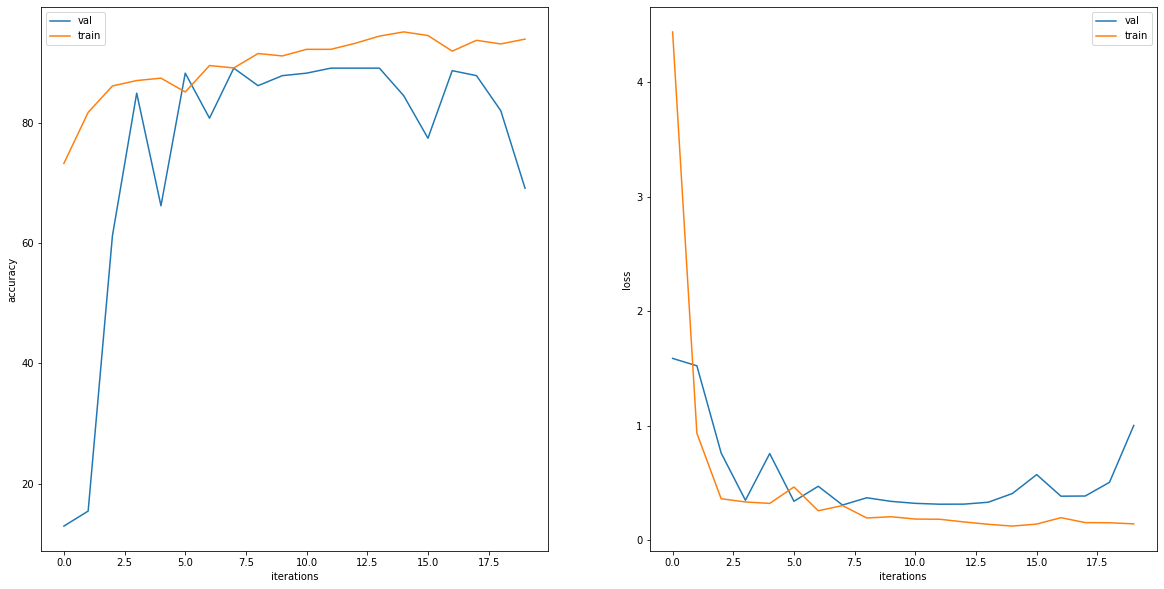

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.title("Training and Validation Accuracy")
print(ax1.title)
ax1.plot(acc_valid,label="val")
ax1.plot(acc_train,label="train")
ax1.set_xlabel("iterations")
ax1.set_ylabel("accuracy")
ax1.legend()

ax2.plot(losses_valid,label="val")
ax2.plot(losses_train,label="train")
ax2.set_xlabel("iterations")
ax2.set_ylabel("loss")
ax2.legend()

# Test dataset and scores

## Accuracy and Loss of test

In [16]:
test_accuracy, test_loss = eval_ep(test_dataloader, model, loss_fn, device, X_test.shape[0], mode=mode)
print(f"Accuracy: {test_accuracy}, loss: {test_loss}\n")

nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, d in enumerate(test_dataloader):
        images = d['images'].to(device)
        targets = d[mode].to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        for t, p in zip(targets, preds):
                confusion_matrix[t, p] += 1

scores = pd.DataFrame(index=['negative', 'positive', 'average'], columns=['precision', 'recall', 'F1-Score'])
for i, label in enumerate(["negative", "positive"]):
    p = scores.loc[label, 'precision'] = (confusion_matrix[i, i] / confusion_matrix[i].sum()).item()
    r = scores.loc[label, 'recall'] = (confusion_matrix[i, i] / confusion_matrix[:, i].sum()).item()
    scores.loc[label, 'F1-Score'] = (2*p*r) / (p+r)
scores.loc['average'] = scores.mean().values

batch 1 / 5 -- loss: 0.15498
batch 2 / 5 -- loss: 0.21594
batch 3 / 5 -- loss: 0.45749
batch 4 / 5 -- loss: 0.32868
batch 5 / 5 -- loss: 0.42110
Accuracy: 90.66666666666666, loss: 0.3156379133462906



## F1 score, precision and recall

In [17]:
scores

,precision,recall,F1-Score
negative,0.980916,0.917857,0.948339
positive,0.394737,0.75,0.517241
average,0.687826,0.833929,0.73279


## confusion matrix

Text(0.5, 57.5, 'Predicted label')

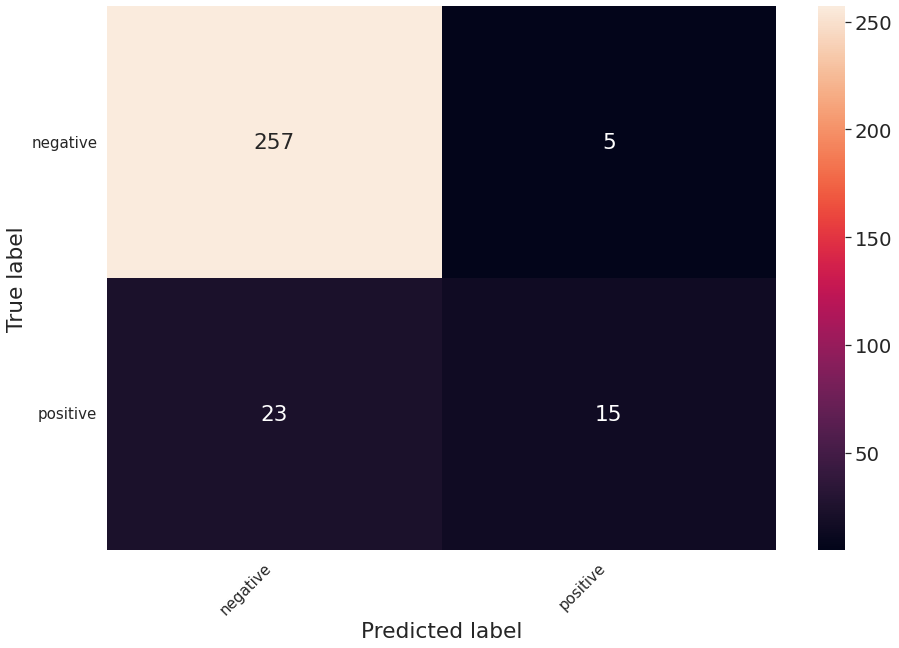

In [18]:
label2class = {0: 'negative', 1: 'positive'}

plt.figure(figsize=(15,10))
sns.set(font_scale=1.8)

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [22]:
!pip install transformers


In [25]:
from transformers import ViTFeatureExtractor, TFAutoModel

def build_vit(input_shape):
    vit_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
    inputs = Input(shape=input_shape)
    features = vit_model(inputs).last_hidden_state
    flattened = Flatten()(features)
    model = Model(inputs, flattened)
    return model


In [27]:
print("X_train shape:", X_train.shape)
print("y_train_vacuole shape:", y_train_vacuole.shape)
print("y_train_acrosome shape:", y_train_acrosome.shape)
print("y_train_head shape:", y_train_head.shape)


X_train shape: (800, 64, 64)
y_train_vacuole shape: (800,)
y_train_acrosome shape: (1000,)
y_train_head shape: (1000,)


In [28]:
# Truncate or reshape to match X_train
y_train_acrosome = y_train_acrosome[:X_train.shape[0]]
y_train_vacuole = y_train_vacuole[:X_train.shape[0]]
y_train_head = y_train_head[:X_train.shape[0]]


In [29]:
X_train, X_val, y_train_vacuole, y_val_vacuole, y_train_acrosome, y_val_acrosome, y_train_head, y_val_head = train_test_split(
    X_train, y_train_vacuole, y_train_acrosome, y_train_head, test_size=0.2, random_state=42
)


In [30]:
# Ensure consistent shapes
print("X_train shape:", X_train.shape)
print("y_train_vacuole shape:", y_train_vacuole.shape)
print("y_train_acrosome shape:", y_train_acrosome.shape)
print("y_train_head shape:", y_train_head.shape)

# Align the number of samples
min_samples = min(X_train.shape[0], y_train_vacuole.shape[0], y_train_acrosome.shape[0], y_train_head.shape[0])
X_train = X_train[:min_samples]
y_train_vacuole = y_train_vacuole[:min_samples]
y_train_acrosome = y_train_acrosome[:min_samples]
y_train_head = y_train_head[:min_samples]

# Split the data consistently
X_train, X_val, y_train_vacuole, y_val_vacuole, y_train_acrosome, y_val_acrosome, y_train_head, y_val_head = train_test_split(
    X_train, y_train_vacuole, y_train_acrosome, y_train_head, test_size=0.2, random_state=42
)


X_train shape: (640, 64, 64)
y_train_vacuole shape: (640,)
y_train_acrosome shape: (640,)
y_train_head shape: (640,)


In [39]:
print("X_train shape:", X_train.shape)


X_train shape: (1000, 64, 64)


In [40]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Custom Dataset class for grayscale images
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images, vacuoles, acrosomes, heads):
        self.images = images / 255.0  # Normalize images to [0, 1]
        self.vacuoles = vacuoles
        self.acrosomes = acrosomes
        self.heads = heads

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        # Add channel dimension for grayscale images
        image = np.expand_dims(self.images[item], axis=0)  # Shape becomes (1, H, W)

        return {
            'images': torch.tensor(image, dtype=torch.float32),
            'vacuoles': torch.tensor(self.vacuoles[item], dtype=torch.long),
            'acrosomes': torch.tensor(self.acrosomes[item], dtype=torch.long),
            'heads': torch.tensor(self.heads[item], dtype=torch.long),
        }

# Dummy data (replace with actual data)
X = np.random.randint(0, 256, size=(1000, 64, 64), dtype=np.uint8)  # Grayscale images
y_vacuole = np.random.randint(0, 2, size=(1000,))  # Binary classification
y_acrosome = np.random.randint(0, 2, size=(1000,))
y_head = np.random.randint(0, 2, size=(1000,))

# Split data into train, validation, and test sets
X_train, X_temp, y_train_vacuole, y_temp_vacuole = train_test_split(X, y_vacuole, test_size=0.4, random_state=42)
X_valid, X_test, y_valid_vacuole, y_test_vacuole = train_test_split(X_temp, y_temp_vacuole, test_size=0.5, random_state=42)

_, _, y_train_acrosome, y_temp_acrosome = train_test_split(X, y_acrosome, test_size=0.4, random_state=42)
_, _, y_valid_acrosome, y_test_acrosome = train_test_split(X_temp, y_temp_acrosome, test_size=0.5, random_state=42)

_, _, y_train_head, y_temp_head = train_test_split(X, y_head, test_size=0.4, random_state=42)
_, _, y_valid_head, y_test_head = train_test_split(X_temp, y_temp_head, test_size=0.5, random_state=42)

# Create datasets
train_dataset = ImagesDataset(
    images=X_train,
    vacuoles=y_train_vacuole,
    acrosomes=y_train_acrosome,
    heads=y_train_head
)
valid_dataset = ImagesDataset(
    images=X_valid,
    vacuoles=y_valid_vacuole,
    acrosomes=y_valid_acrosome,
    heads=y_valid_head
)
test_dataset = ImagesDataset(
    images=X_test,
    vacuoles=y_test_vacuole,
    acrosomes=y_test_acrosome,
    heads=y_test_head
)

# Create DataLoaders
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Test the DataLoader
for batch in train_dataloader:
    print("Batch Images Shape:", batch['images'].shape)  # Expected: (BATCH_SIZE, 1, 64, 64)
    print("Batch Vacuoles Shape:", batch['vacuoles'].shape)  # Expected: (BATCH_SIZE,)
    print("Batch Acrosomes Shape:", batch['acrosomes'].shape)  # Expected: (BATCH_SIZE,)
    print("Batch Heads Shape:", batch['heads'].shape)  # Expected: (BATCH_SIZE,)
    break  # Only print the first batch


Batch Images Shape: torch.Size([64, 1, 64, 64])
Batch Vacuoles Shape: torch.Size([64])
Batch Acrosomes Shape: torch.Size([64])
Batch Heads Shape: torch.Size([64])


In [2]:
import numpy as np
import torch

# Dataset paths and loading
X_train = np.load('/kaggle/input/mhsmadataset/x_64_train.npy')  # Shape: (1000, 64, 64)
y_train_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_train.npy')  # Shape: (1000,)
y_train_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_train.npy')  # Shape: (1000,)
y_train_head = np.load('/kaggle/input/mhsmadataset/y_head_train.npy')  # Shape: (1000,)

X_valid = np.load('/kaggle/input/mhsmadataset/x_64_valid.npy')  # Shape: (240, 64, 64)
y_valid_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_valid.npy')  # Shape: (240,)
y_valid_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_valid.npy')  # Shape: (240,)
y_valid_head = np.load('/kaggle/input/mhsmadataset/y_head_valid.npy')  # Shape: (240,)

X_test = np.load('/kaggle/input/mhsmadataset/x_64_test.npy')  # Shape: (300, 64, 64)
y_test_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_test.npy')  # Shape: (300,)
y_test_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_test.npy')  # Shape: (300,)
y_test_head = np.load('/kaggle/input/mhsmadataset/y_head_test.npy')  # Shape: (300,)

# Step 1: Data Preprocessing
def preprocess_data(X, y_vacuole, y_acrosome, y_head):
    """
    Preprocess the dataset:
    1. Normalize grayscale images.
    2. Add a channel dimension to match PyTorch's format: (N, C, H, W).
    3. Combine the label arrays into a single tensor.
    """
    # Normalize images and add a channel dimension (for grayscale, channel=1)
    X = torch.tensor(X).unsqueeze(1).float() / 255.0  # Shape: (N, 1, 64, 64)
    
    # Combine labels into a single tensor
    y = torch.tensor(np.column_stack((y_vacuole, y_acrosome, y_head))).float()  # Shape: (N, 3)
    
    return X, y

# Preprocess datasets
X_train, y_train = preprocess_data(X_train, y_train_vacuole, y_train_acrosome, y_train_head)
X_valid, y_valid = preprocess_data(X_valid, y_valid_vacuole, y_valid_acrosome, y_valid_head)
X_test, y_test = preprocess_data(X_test, y_test_vacuole, y_test_acrosome, y_test_head)

# Verify processed shapes
print(f"Processed Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
import numpy as np
import torch

# Dataset paths and loading
X_train = np.load('/kaggle/input/mhsmadataset/x_64_train.npy')  # Shape: (1000, 64, 64)
y_train_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_train.npy')  # Shape: (1000,)
y_train_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_train.npy')  # Shape: (1000,)
y_train_head = np.load('/kaggle/input/mhsmadataset/y_head_train.npy')  # Shape: (1000,)

X_valid = np.load('/kaggle/input/mhsmadataset/x_64_valid.npy')  # Shape: (240, 64, 64)
y_valid_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_valid.npy')  # Shape: (240,)
y_valid_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_valid.npy')  # Shape: (240,)
y_valid_head = np.load('/kaggle/input/mhsmadataset/y_head_valid.npy')  # Shape: (240,)

X_test = np.load('/kaggle/input/mhsmadataset/x_64_test.npy')  # Shape: (300, 64, 64)
y_test_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_test.npy')  # Shape: (300,)
y_test_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_test.npy')  # Shape: (300,)
y_test_head = np.load('/kaggle/input/mhsmadataset/y_head_test.npy')  # Shape: (300,)

# Step 1: Data Preprocessing
def preprocess_data(X, y_vacuole, y_acrosome, y_head):
    """
    Preprocess the dataset:
    1. Normalize grayscale images.
    2. Add a channel dimension to match PyTorch's format: (N, C, H, W).
    3. Combine the label arrays into a single tensor.
    """
    # Normalize images and add a channel dimension (for grayscale, channel=1)
    X = torch.tensor(X).unsqueeze(1).float() / 255.0  # Shape: (N, 1, 64, 64)
    
    # Combine labels into a single tensor
    y = torch.tensor(np.column_stack((y_vacuole, y_acrosome, y_head))).float()  # Shape: (N, 3)
    
    return X, y

# Preprocess datasets
X_train, y_train = preprocess_data(X_train, y_train_vacuole, y_train_acrosome, y_train_head)
X_valid, y_valid = preprocess_data(X_valid, y_valid_vacuole, y_valid_acrosome, y_valid_head)
X_test, y_test = preprocess_data(X_test, y_test_vacuole, y_test_acrosome, y_test_head)

# Verify processed shapes
print(f"Processed Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Processed Dataset Shapes:
X_train: torch.Size([1000, 1, 64, 64]), y_train: torch.Size([1000, 3])
X_valid: torch.Size([240, 1, 64, 64]), y_valid: torch.Size([240, 3])
X_test: torch.Size([300, 1, 64, 64]), y_test: torch.Size([300, 3])
Processed Dataset Shapes:
X_train: torch.Size([1000, 1, 64, 64]), y_train: torch.Size([1000, 3])
X_valid: torch.Size([240, 1, 64, 64]), y_valid: torch.Size([240, 3])
X_test: torch.Size([300, 1, 64, 64]), y_test: torch.Size([300, 3])


In [10]:
# Vision Transformer Replacement with Prebuilt ResNet (Kaggle Environment)

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torchvision.models as models

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset paths and loading
X_train = np.load('/kaggle/input/mhsmadataset/x_64_train.npy')
y_train_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_train.npy')
y_train_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_train.npy')
y_train_head = np.load('/kaggle/input/mhsmadataset/y_head_train.npy')

X_val = np.load('/kaggle/input/mhsmadataset/x_64_valid.npy')
y_val_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_valid.npy')
y_val_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_valid.npy')
y_val_head = np.load('/kaggle/input/mhsmadataset/y_head_valid.npy')

X_test = np.load('/kaggle/input/mhsmadataset/x_64_test.npy')
y_test_vacuole = np.load('/kaggle/input/mhsmadataset/y_vacuole_test.npy')
y_test_acrosome = np.load('/kaggle/input/mhsmadataset/y_acrosome_test.npy')
y_test_head = np.load('/kaggle/input/mhsmadataset/y_head_test.npy')

# Check Dataset Shapes
print("Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train_vacuole: {y_train_vacuole.shape}, y_train_acrosome: {y_train_acrosome.shape}, y_train_head: {y_train_head.shape}")
print(f"X_val: {X_val.shape}, y_val_vacuole: {y_val_vacuole.shape}, y_val_acrosome: {y_val_acrosome.shape}, y_val_head: {y_val_head.shape}")
print(f"X_test: {X_test.shape}, y_test_vacuole: {y_test_vacuole.shape}, y_test_acrosome: {y_test_acrosome.shape}, y_test_head: {y_test_head.shape}")

# Preprocess data
def preprocess_data(X, y_vacuole, y_acrosome, y_head):
    X = torch.tensor(X).unsqueeze(1).repeat(1, 3, 1, 1).float() / 255.0  # Normalize and adjust channel
    y = torch.tensor(np.column_stack((y_vacuole, y_acrosome, y_head))).float()
    return X, y

X_train, y_train = preprocess_data(X_train, y_train_vacuole, y_train_acrosome, y_train_head)
X_val, y_val = preprocess_data(X_val, y_val_vacuole, y_val_acrosome, y_val_head)
X_test, y_test = preprocess_data(X_test, y_test_vacuole, y_test_acrosome, y_test_head)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize ResNet Model
model = models.resnet18(pretrained=True)  # Use ResNet-18 as an example
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust the output layer for 3 labels
model.to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training and evaluation logic remains unchanged
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

train_loss, val_loss = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

# Visualize training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

# Evaluation on test data
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    r2 = r2_score(all_labels, all_preds, multioutput='uniform_average')
    print(f"R2 Score: {r2:.4f}")

    return all_preds, all_labels

preds, labels = evaluate_model(model, test_loader)

# Save the model
model_save_path = "resnet18_mhsma_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Using device: cpu
Dataset Shapes:
X_train: (1000, 64, 64), y_train_vacuole: (1000,), y_train_acrosome: (1000,), y_train_head: (1000,)
X_val: (240, 64, 64), y_val_vacuole: (240,), y_val_acrosome: (240,), y_val_head: (240,)
X_test: (300, 64, 64), y_test_vacuole: (300,), y_test_acrosome: (300,), y_test_head: (300,)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [7]:
pip install --upgrade transformers torch


^C
Note: you may need to restart the kernel to use updated packages.


ImportError: cannot import name 'AutoImageProcessor' from 'transformers' (/opt/conda/lib/python3.7/site-packages/transformers/__init__.py)